# Calculating $\Sigma_{10}$


In the context of the paper "[The Sloan Lens ACS Survey. VIII. The Relation between Environment and Internal Structure of Early-Type Galaxies](https://arxiv.org/pdf/0806.1056.pdf)," the projected number density of galaxies inside the tenth nearest neighbor ($\Sigma_{10}$) refers to a measure of the local galaxy density surrounding a target early-type galaxy.

To explain this concept from the paper, we need to understand how the authors calculated $\Sigma_{10}$ and its significance in studying the relationship between galaxy environment and the internal structure of early-type galaxies.

1. Calculation of $\Sigma_{10}$:
In the paper, the authors studied a sample of early-type galaxies with measured gravitational lensing effects. For each target early-type galaxy, they identified its ten nearest neighbor galaxies based on their projected angular distances. The projected angular distance is the angular separation between the target galaxy and its neighbors as seen from our perspective on Earth.

$\Sigma_{10}$ is then calculated as the number of galaxies (including the target galaxy itself) within the combined area covered by the ten nearest neighbors, divided by the total area of that region. In other words, $\Sigma_{10}$ represents the number density of galaxies in the vicinity of the target galaxy, considering the influence of its ten closest neighbors.

2. Significance of $\Sigma_{10}$:
The projected number density $\Sigma_{10}$ is a crucial parameter to study the local galaxy environment around each early-type galaxy in the sample. It provides a measure of the galaxy density on small scales, capturing the immediate gravitational influences of nearby galaxies on the target galaxy.

By analyzing the correlation between $\Sigma_{10}$ and the internal properties of early-type galaxies (such as their effective radii and velocity dispersions), the authors can explore how the local galaxy environment affects the structure and evolution of early-type galaxies. High $\Sigma_{10}$ values imply dense environments with strong gravitational interactions, which might have implications for the growth and assembly history of the early-type galaxies.

In summary, $\Sigma_{10}$ quantifies the local galaxy density surrounding each target early-type galaxy in the sample. It plays a crucial role in understanding the impact of the immediate environment on the internal properties and evolution of these galaxies, providing insights into the complex interplay between galaxy environment and galaxy structure.

Finally calculations can be made by
$$\Sigma_{10} = 10/(\pi R_{10}^2)$$

## Issue for task

https://github.com/ajshajib/BDLensing/issues/191

We've to reproduce **figure no 4** of the SLACS paper for our paper.

## Load data

In [1]:
!pip install photutils

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.datasets import load_star_image
from photutils.aperture import CircularAperture
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog
from astropy.visualization import simple_norm
from photutils.aperture import CircularAnnulus, CircularAperture



from google.colab import drive

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
Mounted at /content/drive


## Load Data

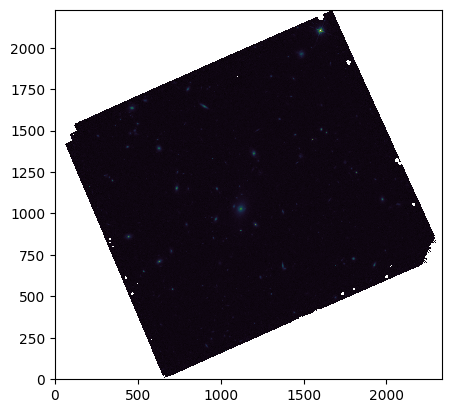

In [3]:
data, header = fits.getdata('/content/drive/MyDrive/BDLensing/DESIJ0132-1600_F140W_drz_sci.fits', header=True)

plt.imshow(np.log10(data), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Background estimation

<ipython-input-4-1b7fe038732e>:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg.background), origin='lower',


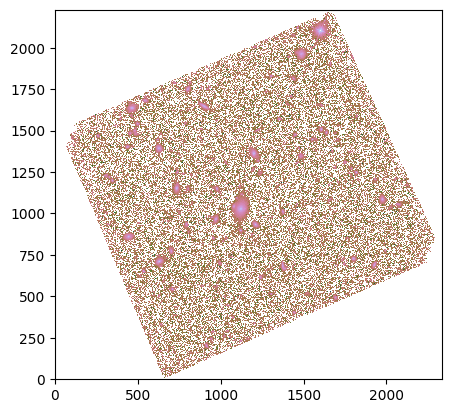

In [4]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

plt.imshow(np.log10(data - bkg.background), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Aperture photometry

In [5]:
np.median(bkg.background), np.median(bkg.background_rms)

bkg_subtracted_data = data - bkg.background

threshold = 5 * bkg.background_rms

segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

segm_deblend = deblend_sources(bkg_subtracted_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)


finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)

<photutils.segmentation.core.SegmentationImage>
shape: (2230, 2336)
nlabels: 398
labels: [  1   2   3   4   5 ... 394 395 396 397 398]
<photutils.segmentation.catalog.SourceCatalog>
Length: 398
labels: [  1   2   3   4   5 ... 394 395 396 397 398]


<ipython-input-12-a10b92251fd4>:4: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(data- bkg.background), origin='lower',


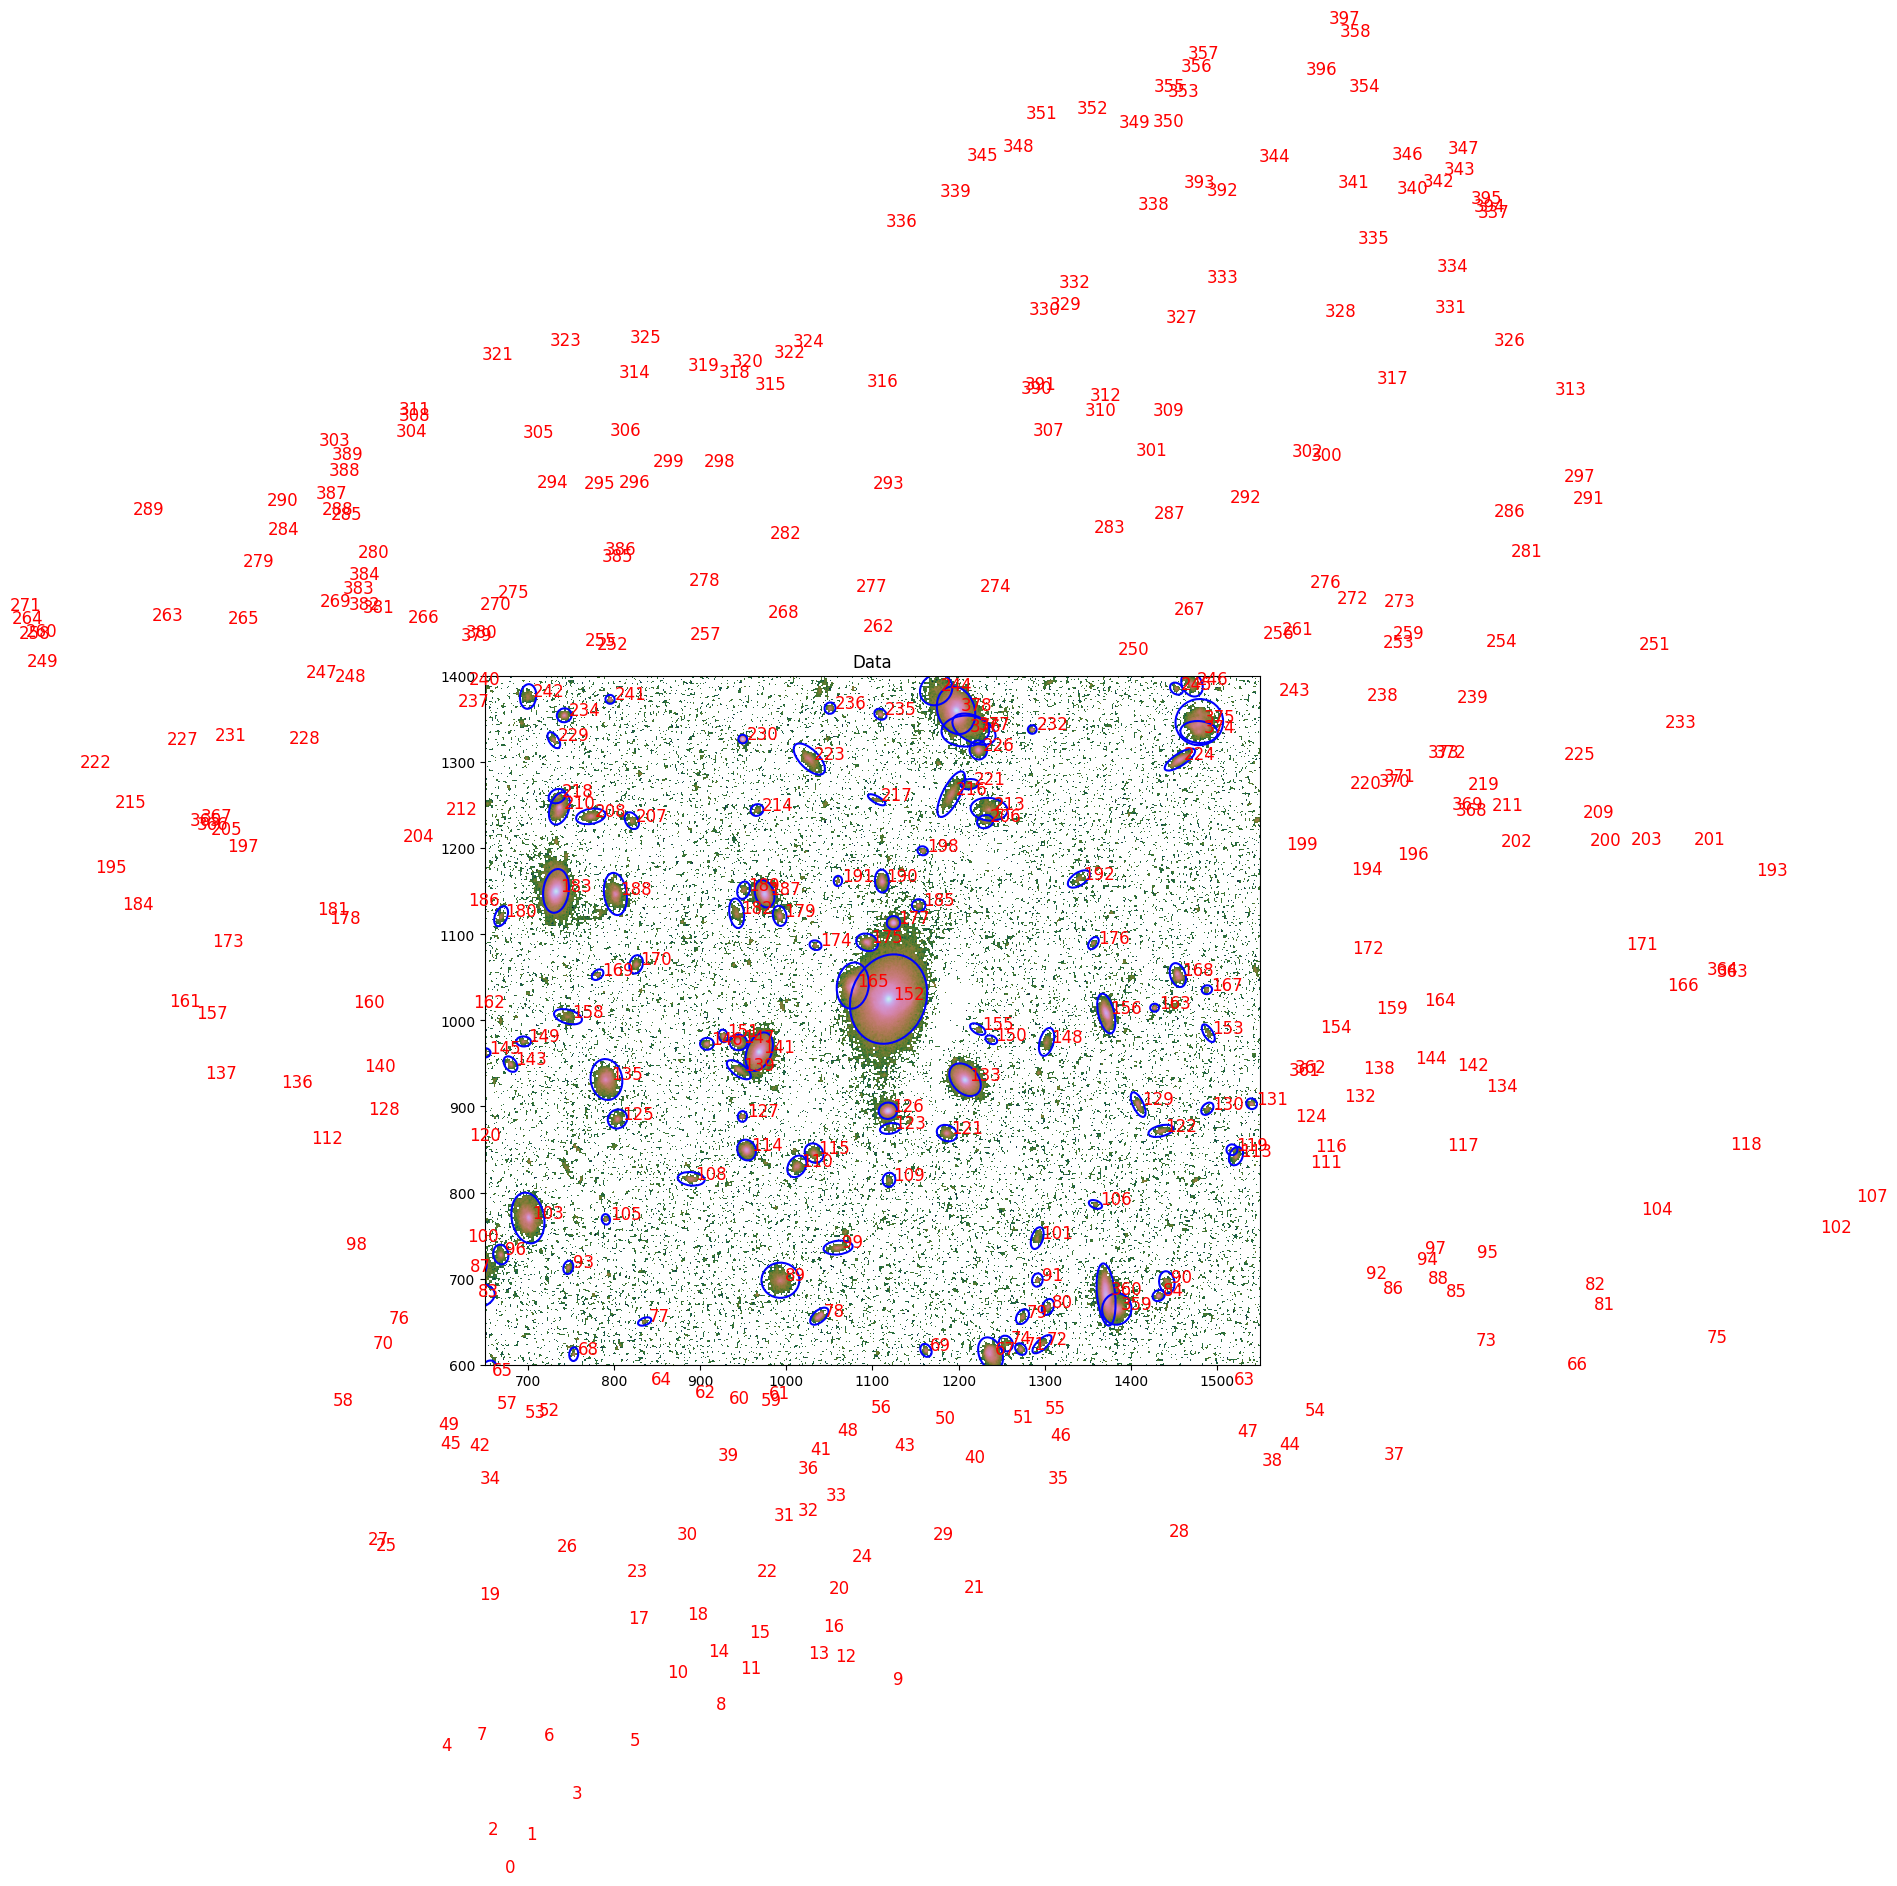

In [12]:
norm = simple_norm(data, 'sqrt')

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(np.log10(data- bkg.background), origin='lower',
           cmap='cubehelix', vmin= -4, vmax= 2)
ax1.set_title('Data')

cat.plot_kron_apertures(ax=ax1, color='blue', lw=1.5);

for i in range(len(cat)):
    ax1.text(cat.xcentroid[i]+5, cat.ycentroid[i],
             f'{i}', c='r', fontsize=12
             #transform=ax1.transAxes
             )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(950-300, 1250+300)
ax1.set_ylim(900-300, 1100+300)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)


## Close Galaxies, Distance, Flux

In [13]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'

In [16]:
# close galaxies

id_central = 152 # object id of your central deflector/lens
highest_id = 378

x0 = tbl['xcentroid'].value[id_central]
y0 = tbl['ycentroid'].value[id_central]
f0 = tbl['kron_flux'].value[id_central]

close_galaxies = []
dist_galaxies = []
flux_galaxies = []
close_galaxies_1_percent_flux = []
dist_galaxies_1_percent_flux = []
flux_galaxies_1_percent_flux = []

for i in range(len(tbl)):
    if i == highest_id:
        continue
    x = tbl['xcentroid'].value[i]
    y = tbl['ycentroid'].value[i]
    f = tbl['kron_flux'].value[i]

    if (np.sqrt((x-x0)**2 + (y-y0)**2) < 20/0.05):
        close_galaxies.append(i)
        flux_galaxies.append(f)
        dist_galaxies.append(np.sqrt((x-x0)**2 + (y-y0)**2))
    if (np.sqrt((x-x0)**2 + (y-y0)**2) < 20/0.05) & (f > f0*0.01):
        close_galaxies_1_percent_flux.append(i)
        flux_galaxies_1_percent_flux.append(f)
        dist_galaxies_1_percent_flux.append(np.sqrt((x-x0)**2 + (y-y0)**2))

print("Close galaxies:", (close_galaxies))
print("Close galaxies_1_percent_flux:", (close_galaxies_1_percent_flux))
print("Number of Close galaxies:", len(close_galaxies))
print("Number of Close galaxies_1_percent_flux:", len(close_galaxies_1_percent_flux))

Close galaxies: [78, 89, 91, 99, 101, 106, 108, 109, 110, 114, 115, 121, 122, 123, 125, 126, 127, 129, 130, 133, 135, 139, 141, 146, 147, 148, 150, 151, 152, 153, 155, 156, 158, 163, 165, 167, 168, 169, 170, 174, 175, 176, 177, 179, 182, 185, 187, 188, 189, 190, 191, 192, 198, 206, 207, 213, 214, 216, 217, 221, 223, 226, 230, 232, 235, 236, 244, 376, 377]
Close galaxies_1_percent_flux: [89, 114, 126, 133, 135, 141, 147, 152, 156, 165, 168, 175, 177, 187, 188, 190, 213, 216, 223, 226, 230, 244, 376, 377]
Number of Close galaxies: 69
Number of Close galaxies_1_percent_flux: 24


## Pixel to Arcsec

In [17]:
def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

### Data frame for close galaxies with and without applying 1% flux filter

In [18]:
n_sys = 1 #number of galaxies detected inside your lensing system

df = pd.DataFrame({'Distance(pixels)': dist_galaxies})
df_1_percent_flux = pd.DataFrame({'Distance(pixels)': dist_galaxies_1_percent_flux})

df.set_index(pd.Index(close_galaxies), inplace=True)
df_1_percent_flux.set_index(pd.Index(close_galaxies_1_percent_flux), inplace=True)

df['Distance(arcsec)'] = distance_arcsec(df['Distance(pixels)'])
df['Flux'] = flux_galaxies
df_1_percent_flux['Distance(arcsec)'] = distance_arcsec(df_1_percent_flux['Distance(pixels)'])
df_1_percent_flux['Flux'] = flux_galaxies_1_percent_flux

# Sort the DataFrame based on 'Distance'
df_sorted = df.sort_values(by='Distance(pixels)')
df_1_percent_flux_sorted = df_1_percent_flux.sort_values(by='Distance(pixels)')

# Exclude the lensing system members
df_sys_removed = df_sorted.iloc[n_sys:]
df_1_percent_flux_sys_removed = df_1_percent_flux_sorted.iloc[n_sys:]

#first 20 galaxies
df_20 = df_sys_removed.iloc[:20]
df_1_percent_flux_20 = df_1_percent_flux_sys_removed.iloc[:20]

print(df_20)
print(df_1_percent_flux_20)

     Distance(pixels)  Distance(arcsec)        Flux
165         44.363882          3.549111  222.265129
175         70.425290          5.634023   35.097931
177         88.863546          7.109084   54.177181
174        105.404935          8.432395    3.255528
155        109.293416          8.743473    3.697351
185        114.335265          9.146821    6.876990
150        128.326741         10.266139    3.051376
133        129.090931         10.327274  402.429428
126        129.713761         10.377101  146.333295
190        137.267593         10.981407   30.807085
191        149.234210         11.938737    2.608702
123        150.290316         12.023225    4.954598
179        159.121590         12.729727   15.713341
141        162.139079         12.971126  401.910618
121        169.745868         13.579669   18.747243
198        176.717360         14.137389    4.129276
147        181.559490         14.524759   36.836687
187        188.937501         15.115000  190.747355
148        1

### $R_{10}$, $R_{20}$ and $\Sigma_{10}$, $\Sigma_{20}$ Calculation Without filtering 1% flux

In [19]:
R_10 = df_20.iloc[9, df.columns.get_loc('Distance(arcsec)')]
R_20 = df_20.iloc[19, df.columns.get_loc('Distance(arcsec)')]
Sigma_10 = 10/(np.pi*R_10**2)
Sigma_20=20/(np.pi*R_20**2)

%store R_10
%store R_20
%store Sigma_10
%store Sigma_20

print("R 10:", R_10)
print("R 20:", R_20)
print("Sigma 10:", Sigma_10)
print("Sigma 20:", Sigma_20)

Stored 'R_10' (float64)
Stored 'R_20' (float64)
Stored 'Sigma_10' (float64)
Stored 'Sigma_20' (float64)
R 10: 10.98140741234701
R 20: 15.37870842875462
Sigma 10: 0.02639575683086577
Sigma 20: 0.026917851747399097


### $R_{10}$, $R_{20}$ and $\Sigma_{10}$, $\Sigma_{20}$ Calculation With filtering 1% flux

In [20]:
R_10_1_percent_flux = df_1_percent_flux_20.iloc[9, df_1_percent_flux.columns.get_loc('Distance(arcsec)')]
R_20_1_percent_flux = df_1_percent_flux_20.iloc[19, df_1_percent_flux.columns.get_loc('Distance(arcsec)')]
Sigma_10_1_percent_flux = 10/(np.pi*R_10_1_percent_flux**2)
Sigma_20_1_percent_flux = 20/(np.pi*R_20_1_percent_flux**2)

%store R_10_1_percent_flux
%store R_20_1_percent_flux
%store Sigma_10_1_percent_flux
%store Sigma_20_1_percent_flux

print("R 10_1_percent_flux:", R_10_1_percent_flux)
print("R 20_1_percent_flux:", R_20_1_percent_flux)
print("Sigma 10_1_percent_flux:", Sigma_10_1_percent_flux)
print("Sigma 20_1_percent_flux:", Sigma_20_1_percent_flux)

Stored 'R_10_1_percent_flux' (float64)
Stored 'R_20_1_percent_flux' (float64)
Stored 'Sigma_10_1_percent_flux' (float64)
Stored 'Sigma_20_1_percent_flux' (float64)
R 10_1_percent_flux: 19.25361662309586
R 20_1_percent_flux: 27.251189651927934
Sigma 10_1_percent_flux: 0.008586684134844407
Sigma 20_1_percent_flux: 0.008572533493818969


### Closest 20 galaxies Without filtering 1% flux Visualized

In [21]:
# 10

df_10 = df_sys_removed.iloc[:10]
galaxies_10 = df_10.index.tolist()

print(galaxies_10)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_10]

aperture_10 = CircularAperture(positions, r=20.0)

# 20
galaxies_20 = df_20.index.tolist()

print(galaxies_20)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_20]

aperture_20 = CircularAperture(positions, r=20.0)

[165, 175, 177, 174, 155, 185, 150, 133, 126, 190]
[165, 175, 177, 174, 155, 185, 150, 133, 126, 190, 191, 123, 179, 141, 121, 198, 147, 187, 148, 139]


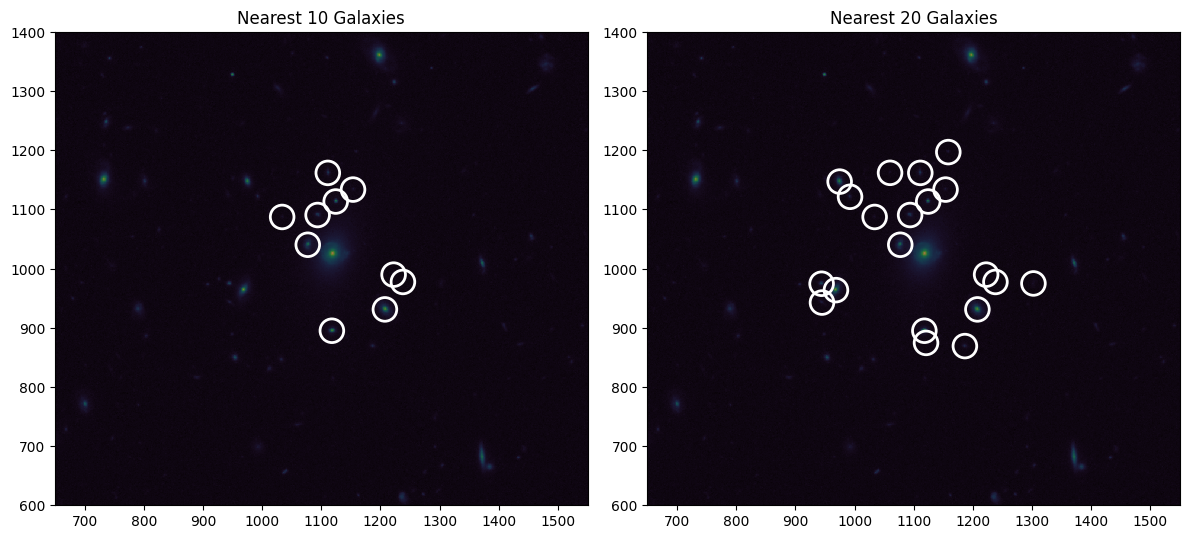

In [25]:
# Create two separate plots

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the nearest 10 galaxies from df_10 in the first subplot
axs[0].imshow(np.log10(data), interpolation='nearest',
              origin='lower', cmap='cubehelix')
aperture_10.plot(color='white', lw=2, ax=axs[0])

axs[0].set_xlim(950-300, 1250+300)
axs[0].set_ylim(900-300, 1100+300)
axs[0].set_title('Nearest 10 Galaxies')

# Plot the nearest 20 galaxies from df_20 in the second subplot
axs[1].imshow(np.log10(data), interpolation='nearest',
              origin='lower', cmap='cubehelix')
aperture_20.plot(color='white', lw=2, ax=axs[1])
axs[1].set_xlim(950-300, 1250+300)
axs[1].set_ylim(900-300, 1100+300)
axs[1].set_title('Nearest 20 Galaxies')


plt.tight_layout()
plt.show()

### Closest 20 galaxies With filtering 1% flux Visualized

In [23]:
# 10

df_1_percent_flux_10 = df_1_percent_flux_sys_removed.iloc[:10]

galaxies_1_percent_flux_10 = df_1_percent_flux_10.index.tolist()

print(galaxies_1_percent_flux_10)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in
             galaxies_1_percent_flux_10]

aperture_10_flux_added = CircularAperture(positions, r=20.0)

# 20

galaxies_1_percent_flux_20 = df_1_percent_flux_20.index.tolist()

print(galaxies_1_percent_flux_20)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in
             galaxies_1_percent_flux_20]

aperture_20_flux_added = CircularAperture(positions, r=20.0)

[165, 175, 177, 133, 126, 190, 141, 147, 187, 114]
[165, 175, 177, 133, 126, 190, 141, 147, 187, 114, 216, 213, 156, 223, 226, 376, 377, 168, 188, 135]


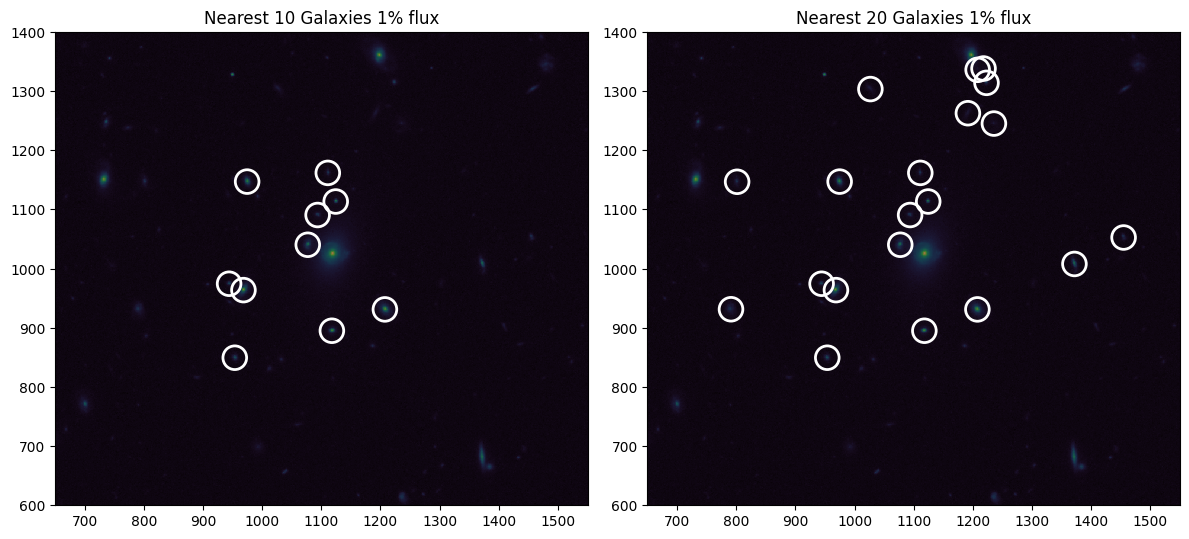

In [26]:
# Create two separate plots

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the nearest 10 galaxies from df_10 in the first subplot
axs[0].imshow(np.log10(data), interpolation='nearest',
              origin='lower', cmap='cubehelix')
aperture_10_flux_added.plot(color='white', lw=2, ax=axs[0])



axs[0].set_xlim(950-300, 1250+300)
axs[0].set_ylim(900-300, 1100+300)
axs[0].set_title('Nearest 10 Galaxies 1% flux')

# Plot the nearest 20 galaxies from df_20 in the second subplot
axs[1].imshow(np.log10(data), interpolation='nearest',
              origin='lower', cmap='cubehelix')
aperture_20_flux_added.plot(color='white', lw=2, ax=axs[1])
axs[1].set_xlim(950-300, 1250+300)
axs[1].set_ylim(900-300, 1100+300)
axs[1].set_title('Nearest 20 Galaxies 1% flux')


plt.tight_layout()
plt.show()